## 루브릭 기준

1. 시계열의 안정성이 충분히 확인되었는가?

플로팅과 adfuller 메소드가 모두 적절히 사용되었음


2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?

p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨


3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?

3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨

## STEP 1. 시계열 데이터 준비

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.

- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [9]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

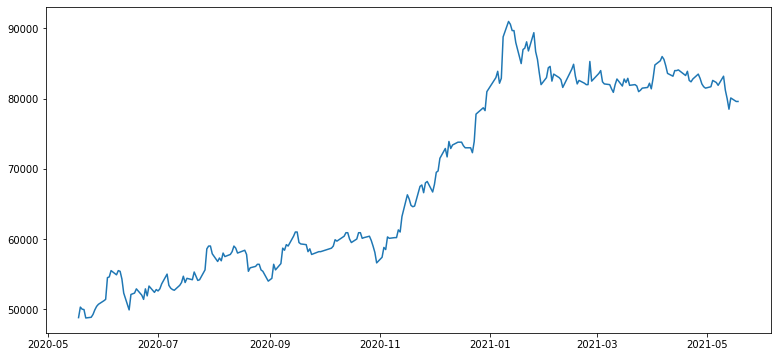

In [10]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

## STEP 2.  각종 전처리 수행

- 결측치 처리

- 로그 변환

In [11]:

# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

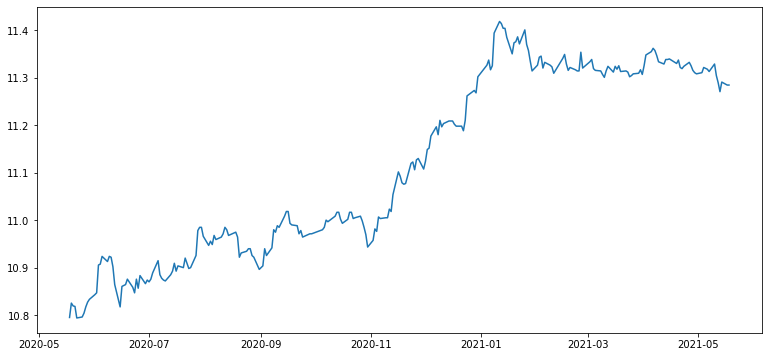

In [12]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## 시계열 안정성 분석

- 정성적 그래프 분석

- 정량적 Augmented Dicky-Fuller Test

- 시계열 분해(Time Series Decomposition)

- Residual 안정성 확인

In [13]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

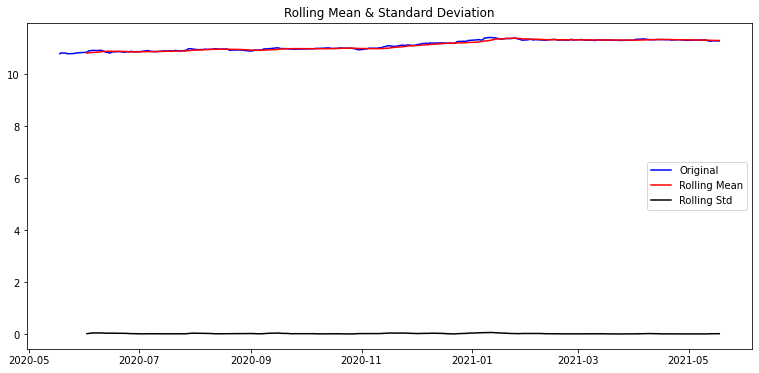

In [14]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [15]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [16]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


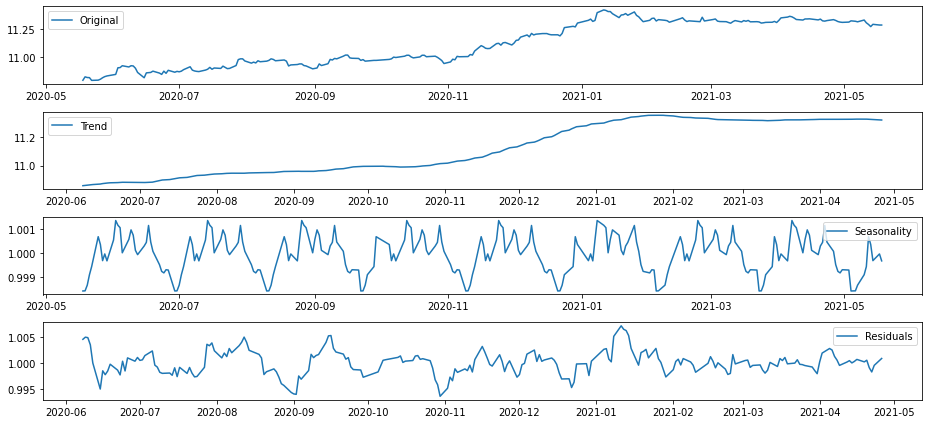

In [17]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

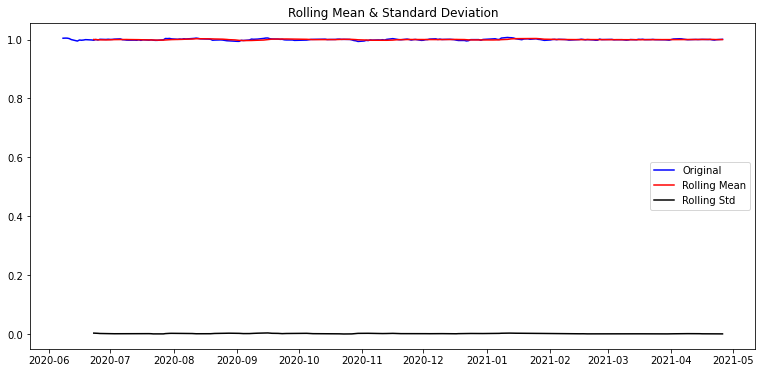

In [18]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [19]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4. 학습, 테스트 데이터셋 생성

- 학습, 테스트 데이터셋 분리

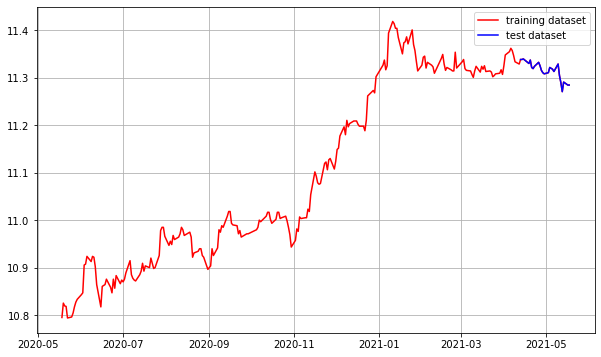

In [20]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5. 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기


- 차분 안정성 확인 -> d 구하기

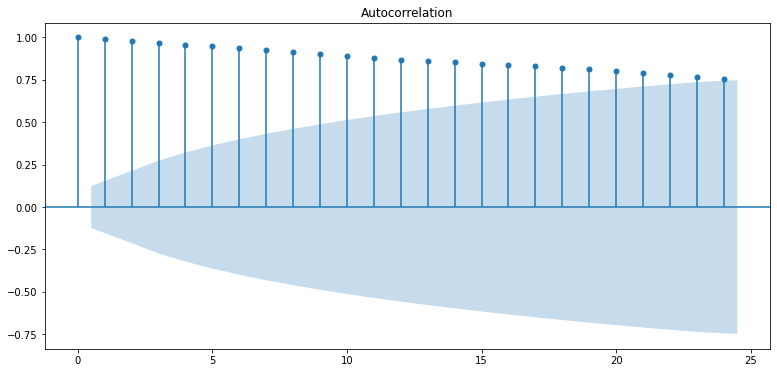

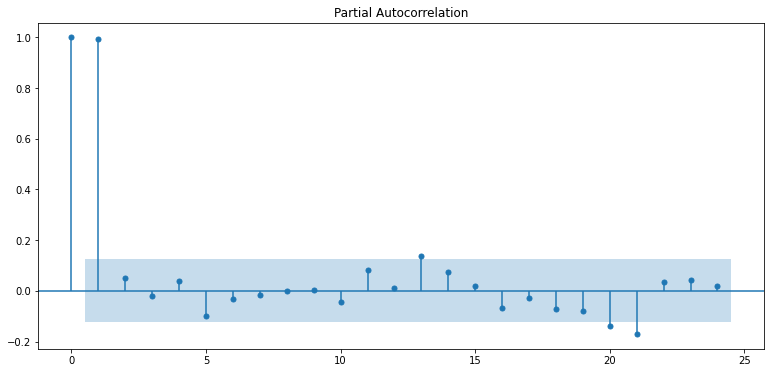

In [21]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


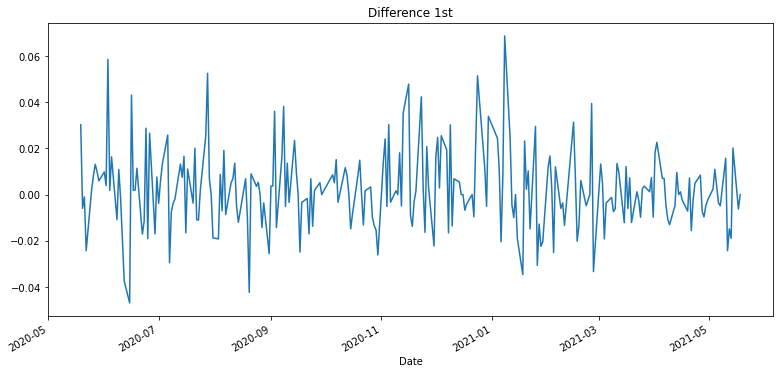

In [22]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


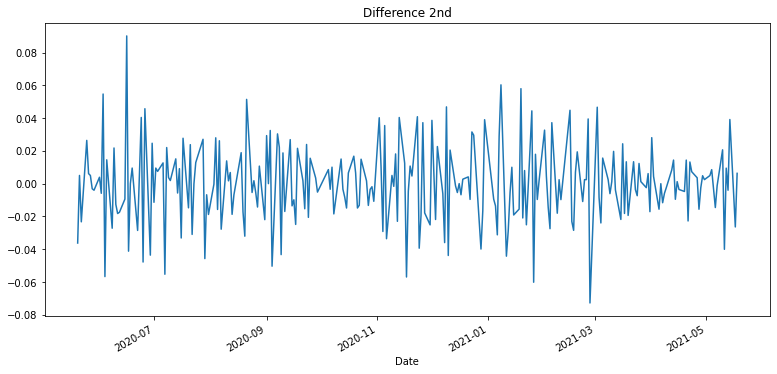

In [23]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


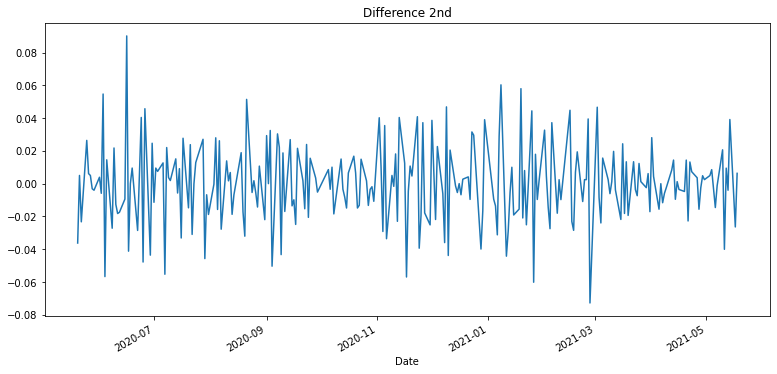

In [24]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6. ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련

- 모델 테스트 및 플로팅

- 최종 예측 모델 정확도 측정(MAPE)

In [39]:

from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 2))  
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 585.719
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 11 Nov 2021   AIC                          -1161.438
Time:                        02:32:24   BIC                          -1144.380
Sample:                             1   HQIC                         -1154.553
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      2.357      0.018       0.000       0.004
ar.L1.D.Close     0.7999      0.495      1.616      0.106      -0.170       1.770
ma.L1.D.Close    -0.7855      0.497     

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


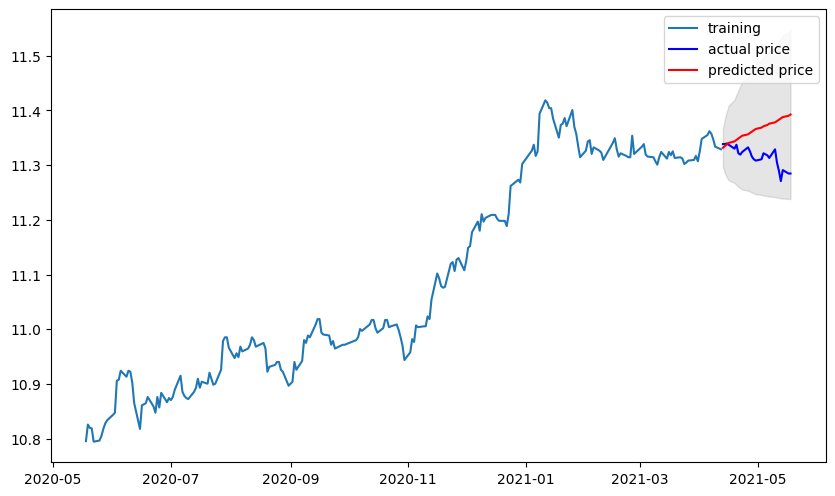

In [40]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,6), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  24810637.96660098
MAE:  4066.355219164387
RMSE:  4981.0278022312805
MAPE: 5.02%


### STEP 7 : 다른 주식 종목 예측해 보기

- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

1. UBER

2. PFIZER

3. Netflix

In [76]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [77]:
def get_time_series_log(filename):
    # Time Series 생성
    dataset_dirpath = os.getenv('HOME') + '/aiffel/stock_prediction/data1'
    dataset_filepath = os.path.join(dataset_dirpath, filename)
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    ts = df['Close']
    # 결측치 처리
    if len(ts[ts.isna()]) > 0:
        ts = ts.interpolate(method='time')
    # 로그 변환
    return np.log(ts)

In [78]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    rcParams['figure.figsize'] = 10, 6
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [79]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [80]:
def check_stationary(ts_log):
    # 정성적 그래프 분석
    plot_rolling_statistics(ts_log, window=12)
    # 정량적 Augmented Dicky-Fuller Test
    augmented_dickey_fuller_test(ts_log)

In [81]:
def time_series_decomposition(ts_log):
    # 시계열 분해 (Time Series Decomposition)
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.rcParams["figure.figsize"] = (12,6)
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

In [82]:
# 학습, 테스트 데이터셋 분리
def split_train_test_data(ts_log):
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    return train_data, test_data

In [83]:

# ACF, PACF 그려보기 -> p,q 구하기
def plot_acf_pacf(ts_log):
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

In [84]:
# 차분 안정성 확인 -> d 구하기
def get_difference(ts_log):
    # 1차 차분 구하기
    plt.subplot(211)
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
    # 혹시 필요한 경우 2차 차분 구하기
    plt.subplot(212)
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    print('Difference 1st:')
    augmented_dickey_fuller_test(diff_1)
    print('\nDifference 2nd:')
    augmented_dickey_fuller_test(diff_2)

In [85]:
def arima_train_test(order):
    # Build and Train  Model
    model = ARIMA(train_data, order=order)
    fitted_m = model.fit(disp=-1)
    print(fitted_m.summary())

    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,6), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

    # Score
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

## UBER

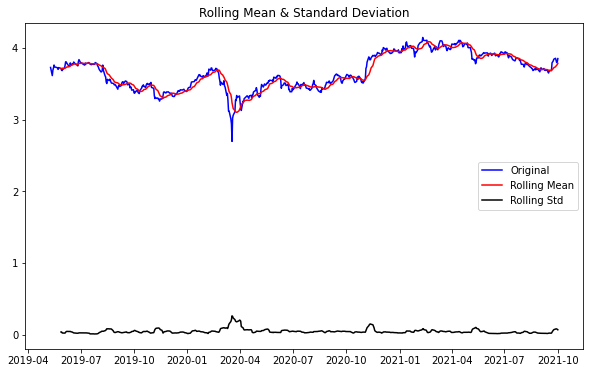

Results of Dickey-Fuller Test:
Test Statistic                  -1.764933
p-value                          0.398005
#Lags Used                      12.000000
Number of Observations Used    592.000000
Critical Value (1%)             -3.441444
Critical Value (5%)             -2.866435
Critical Value (10%)            -2.569377
dtype: float64


In [114]:
# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('UBER.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -8.060976e+00
p-value                        1.643368e-12
#Lags Used                     1.200000e+01
Number of Observations Used    5.620000e+02
Critical Value (1%)           -3.442039e+00
Critical Value (5%)           -2.866697e+00
Critical Value (10%)          -2.569516e+00
dtype: float64


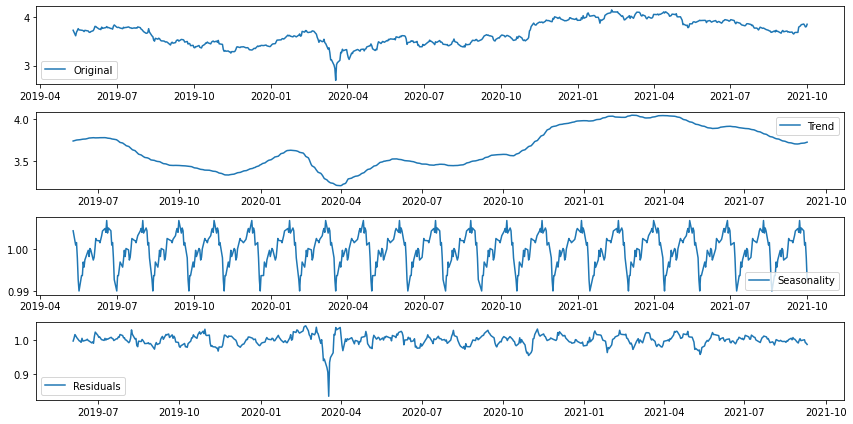

In [115]:
# 시계열 분해
time_series_decomposition(ts_log)

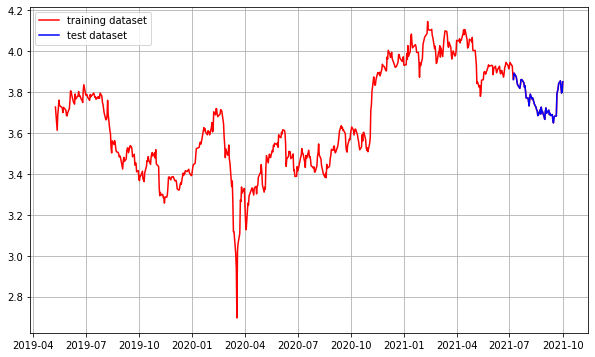

In [116]:
train_data, test_data = split_train_test_data(ts_log)

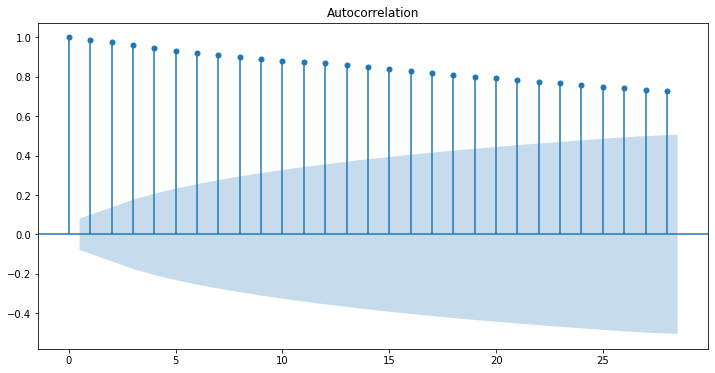

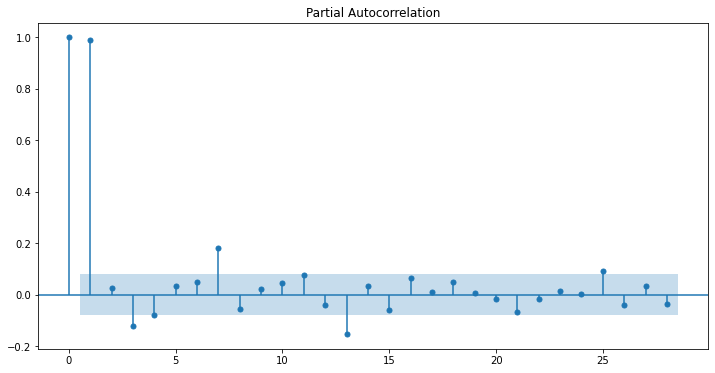

In [117]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                -6.720766e+00
p-value                        3.487889e-09
#Lags Used                     1.100000e+01
Number of Observations Used    5.920000e+02
Critical Value (1%)           -3.441444e+00
Critical Value (5%)           -2.866435e+00
Critical Value (10%)          -2.569377e+00
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -9.876297e+00
p-value                        3.874459e-17
#Lags Used                     1.800000e+01
Number of Observations Used    5.840000e+02
Critical Value (1%)           -3.441597e+00
Critical Value (5%)           -2.866502e+00
Critical Value (10%)          -2.569412e+00
dtype: float64


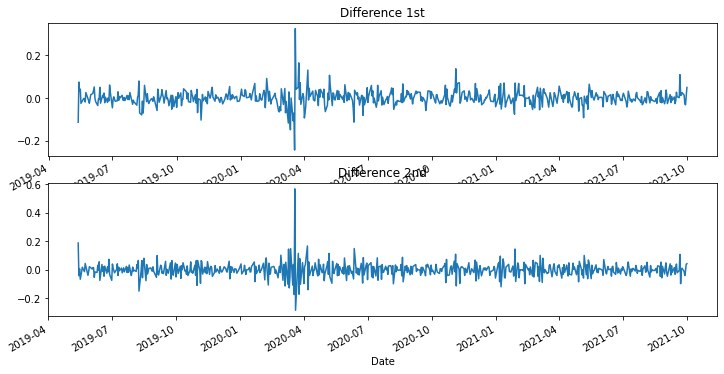

In [118]:

# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  543
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1003.968
Method:                       css-mle   S.D. of innovations              0.038
Date:                Thu, 11 Nov 2021   AIC                          -2001.937
Time:                        04:53:30   BIC                          -1989.046
Sample:                             1   HQIC                         -1996.896
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.002      0.181      0.856      -0.003       0.003
ma.L1.D.Close    -0.0093      0.039     -0.237      0.812      -0.086       0.068
                                    Root

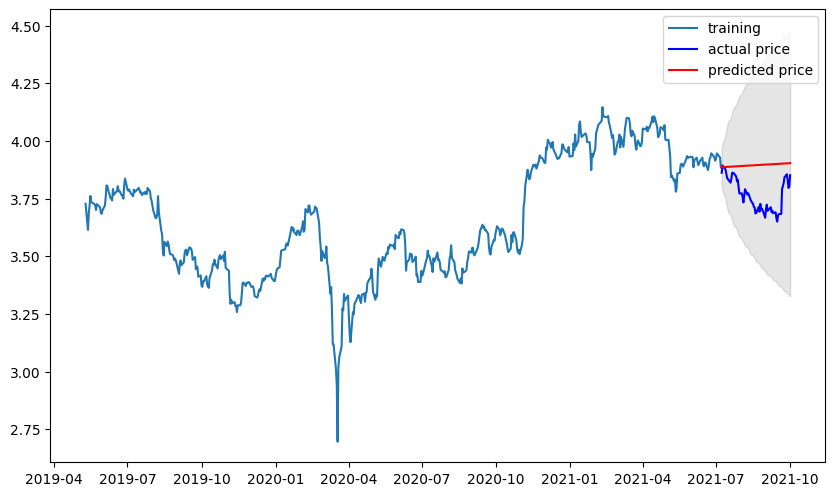

MSE:  43.80570954183871
MAE:  5.852361596251585
RMSE:  6.618588183429961
MAPE: 14.07%


In [119]:
# ARIMA 모델 훈련 및 테스트
arima_train_test((0, 1, 1))

## PFIZER

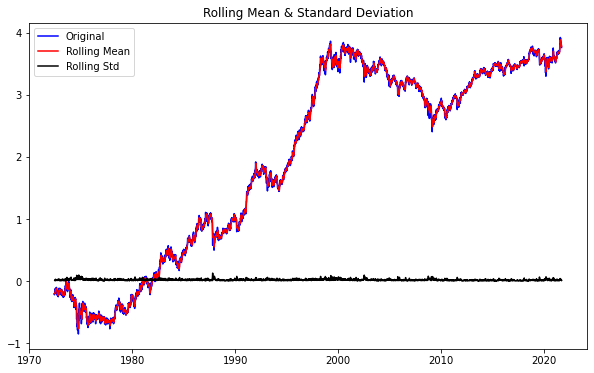

Results of Dickey-Fuller Test:
Test Statistic                    -0.790762
p-value                            0.821821
#Lags Used                         6.000000
Number of Observations Used    12436.000000
Critical Value (1%)               -3.430876
Critical Value (5%)               -2.861772
Critical Value (10%)              -2.566894
dtype: float64


In [129]:

# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('PFE.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

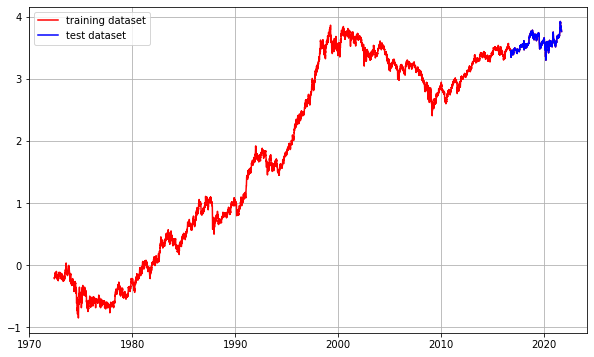

In [131]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = split_train_test_data(ts_log)

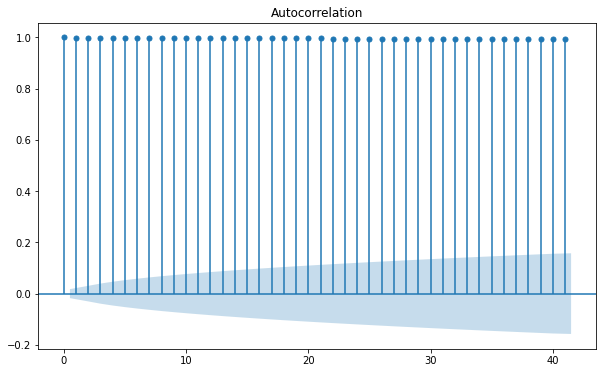

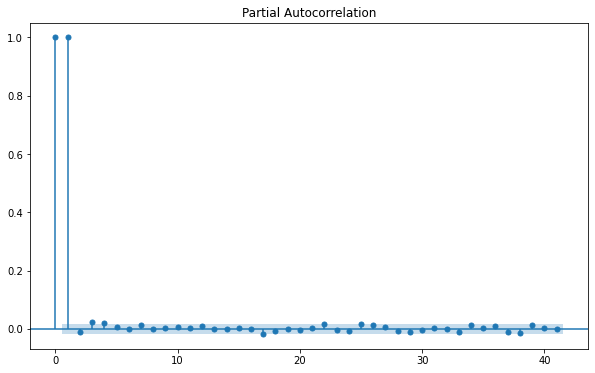

In [132]:

# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                   -48.729090
p-value                            0.000000
#Lags Used                         5.000000
Number of Observations Used    12436.000000
Critical Value (1%)               -3.430876
Critical Value (5%)               -2.861772
Critical Value (10%)              -2.566894
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                   -30.289424
p-value                            0.000000
#Lags Used                        41.000000
Number of Observations Used    12399.000000
Critical Value (1%)               -3.430878
Critical Value (5%)               -2.861773
Critical Value (10%)              -2.566894
dtype: float64


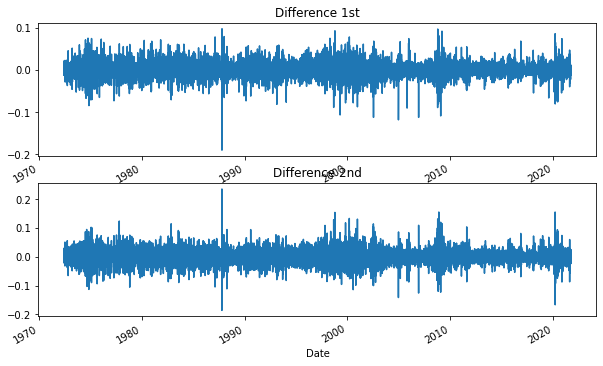

In [133]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                11197
Model:                 ARIMA(0, 1, 1)   Log Likelihood               29299.844
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 11 Nov 2021   AIC                         -58593.689
Time:                        04:57:45   BIC                         -58571.718
Sample:                             1   HQIC                        -58586.293
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      1.910      0.056   -8.49e-06       0.001
ma.L1.D.Close     0.0173      0.010      1.731      0.083      -0.002       0.037
                                    Root

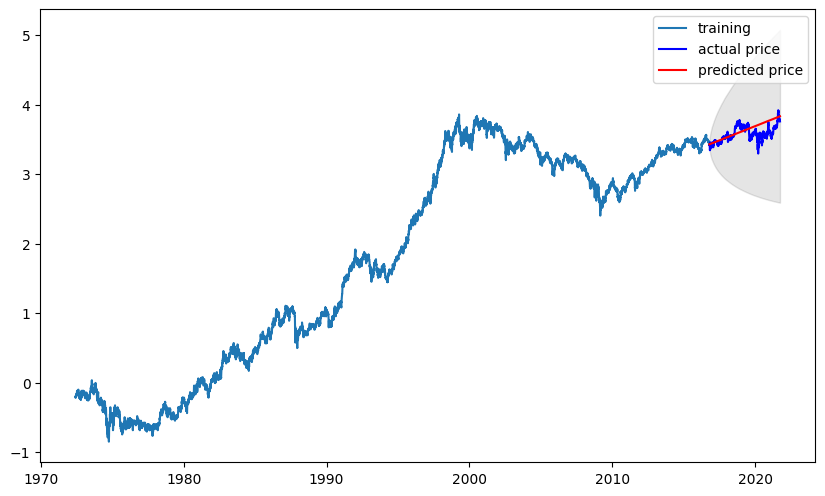

MSE:  21.118591453595364
MAE:  3.550460159715967
RMSE:  4.595496866889952
MAPE: 9.92%


In [134]:
# ARIMA 모델 훈련 및 테스트
arima_train_test((0, 1, 1))

## Netflix

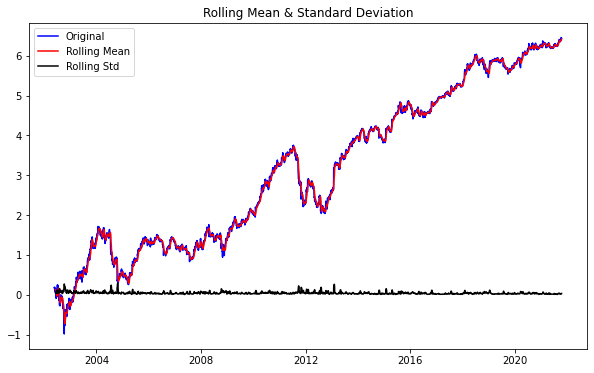

Results of Dickey-Fuller Test:
Test Statistic                   -0.435696
p-value                           0.903966
#Lags Used                        1.000000
Number of Observations Used    4879.000000
Critical Value (1%)              -3.431691
Critical Value (5%)              -2.862133
Critical Value (10%)             -2.567085
dtype: float64


In [122]:
# 데이터 불러와 Time Series 생성하기
ts_log = get_time_series_log('netflix.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

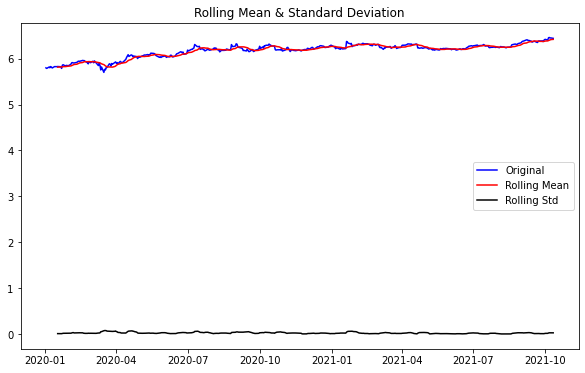

Results of Dickey-Fuller Test:
Test Statistic                  -1.635174
p-value                          0.464783
#Lags Used                      15.000000
Number of Observations Used    432.000000
Critical Value (1%)             -3.445578
Critical Value (5%)             -2.868254
Critical Value (10%)            -2.570346
dtype: float64


In [123]:

ts_log = ts_log['2020-01-01':]
check_stationary(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -6.935797e+00
p-value                        1.055485e-09
#Lags Used                     1.800000e+01
Number of Observations Used    3.990000e+02
Critical Value (1%)           -3.446846e+00
Critical Value (5%)           -2.868811e+00
Critical Value (10%)          -2.570643e+00
dtype: float64


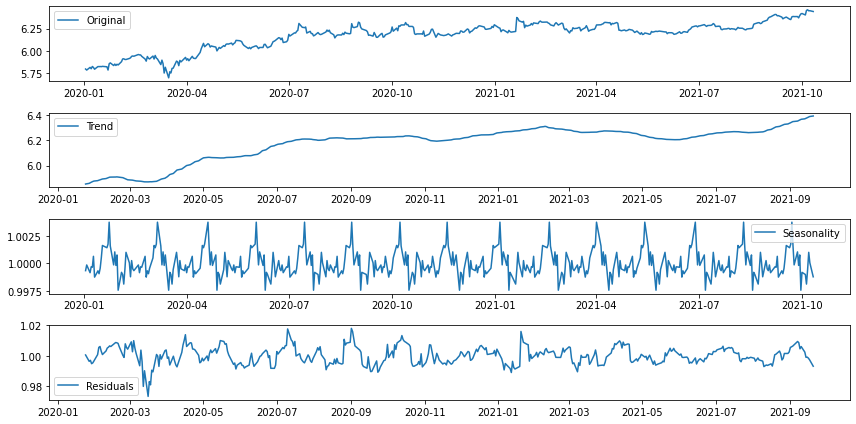

In [124]:
# 시계열 분해
time_series_decomposition(ts_log)

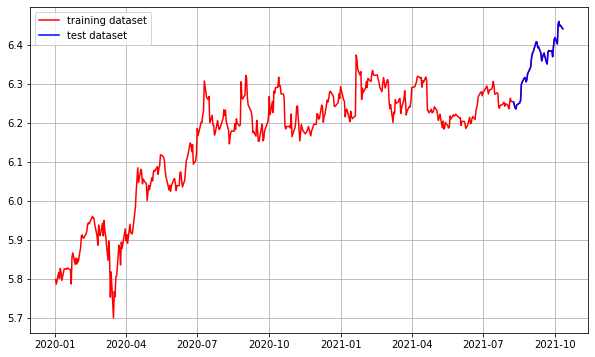

In [125]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = split_train_test_data(ts_log)

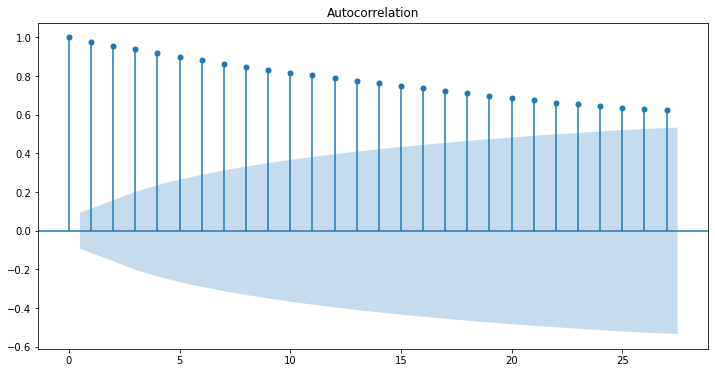

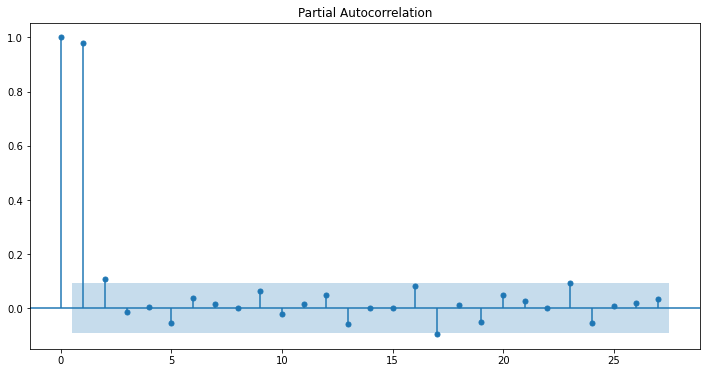

In [126]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                -6.285591e+00
p-value                        3.704950e-08
#Lags Used                     1.400000e+01
Number of Observations Used    4.320000e+02
Critical Value (1%)           -3.445578e+00
Critical Value (5%)           -2.868254e+00
Critical Value (10%)          -2.570346e+00
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -9.424416e+00
p-value                        5.394634e-16
#Lags Used                     1.600000e+01
Number of Observations Used    4.290000e+02
Critical Value (1%)           -3.445685e+00
Critical Value (5%)           -2.868301e+00
Critical Value (10%)          -2.570371e+00
dtype: float64


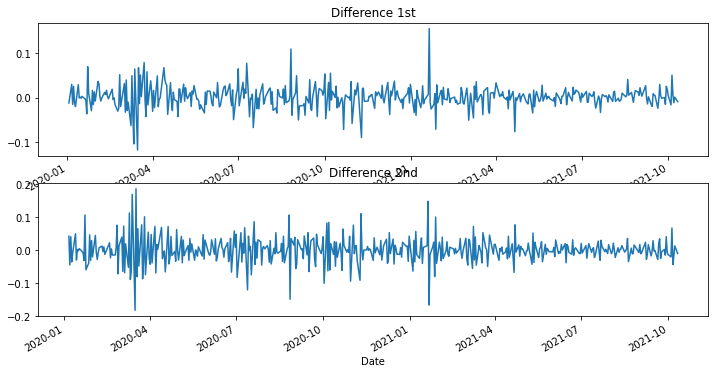

In [127]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  402
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 897.114
Method:                       css-mle   S.D. of innovations              0.026
Date:                Thu, 11 Nov 2021   AIC                          -1788.227
Time:                        04:55:22   BIC                          -1776.238
Sample:                             1   HQIC                         -1783.480
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      1.118      0.263      -0.001       0.003
ma.L1.D.Close    -0.2120      0.046     -4.570      0.000      -0.303      -0.121
                                    Root

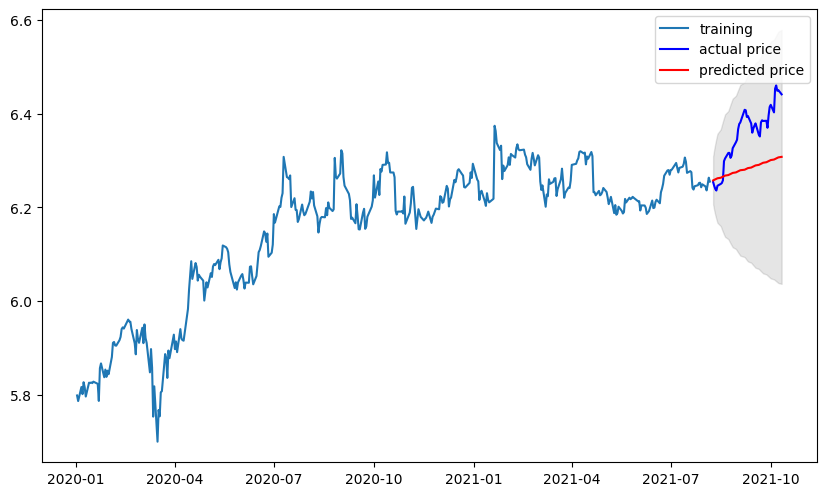

MSE:  2484.127717600585
MAE:  43.21072905835346
RMSE:  49.84102444373094
MAPE: 7.27%


In [128]:
# ARIMA 모델 훈련 및 테스트
arima_train_test((0, 1, 1))

### 프로젝트 회고

처음에는 MAPE를 어떻게 낮춰야할지 몰라서 Kaggle에다가 stock를 치고 아무 데이터나 막 넣어서 돌렸더니 MAPE수치가 30%가 넘는 데이터들이었습니다. 그래서 어떻게 하면 15%을 줄이까하다가 좋은 아이디어가 떠올랐습니다.

MAPE를 낮추는 방법은 당연히 변동 폭이 크지 않고 꾸준하게 성장한 여러 대기업 계열사 종목이나 기간 조정을 통해서 만드는 방법입니다.

그러다보니 제가 현재 해외 주식을 하고 있고 그 중에서 실제로 가장 관심있는 세 종목을 선택했습니다!!

노드 하면서 흥미있었고 재미났지만 이걸 가지고 주식하면 망할 것 같아요 ..